In [23]:
import os
import nglview as ng
import gromacs as gmx
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re
import mdtraj as md
%matplotlib widget

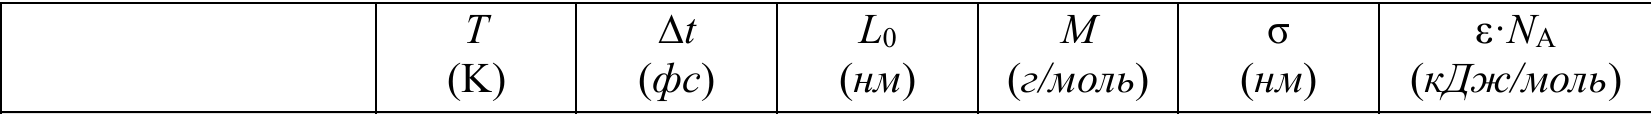

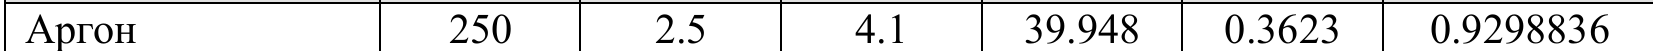

Изменил single.gro файл, чтобы размерв ячейки были $0,41^3$, чтобы после размножения получить требуемую $L_0$. Частицу поместил в центр ячейки

In [23]:
!cat single.gro

the only LJ atom in the cell
    1
    1RESID Ar    1   0.205   0.205   0.205  0.1324  0.1307  0.0385
   0.41000   0.41000   0.41000


Размножил частицу в 1000 раз, получил ячейку размером $4.1^3$ нм

In [25]:
!gmx genconf -f single.gro -nbox 10 10 10 -o 0/Ar_0

               :-) GROMACS - gmx genconf, 2025.4-conda_forge (-:

Executable:   /home/ivank/miniconda3/bin.AVX2_256/gmx
Data prefix:  /home/ivank/miniconda3
Working dir:  /home/ivank/tasks/task_3
Command line:
  gmx genconf -f single.gro -nbox 10 10 10 -o 0/Ar_0


GROMACS reminds you: "Cut It Deep and Cut It Wide" (The Walkabouts)



Визуализация изначальной структуры до проведения первого моделирования:

In [30]:
view = ng.show_structure_file("0/Ar_0.gro")
view.render_image()

Image(value=b'', width='99%')

In [21]:
os.chdir("0")

Провел 11 моделирований, в каждом объем ячейки увеличивался в $1.3^3$ по отношению к предыдущему. Результаты расчетов сохранены в папках с именами, соответствующими номеру расчета

In [ ]:
for i in range(1, 12):
    os.mkdir(f"../{i}")
    os.chdir(f"../{i}")
    if i == 1:
        scale_factor = 1
    else: scale_factor = 1.2
    gmx.editconf(f=f"../{i-1}/Ar_{i-1}.gro",
            o=f"Ar_{i-1}_scaled",
            scale=f"{scale_factor}")
    gmx.grompp(f="../mdp.mdp",
          c=f"Ar_{i-1}_scaled",
          p="../Ar.top",
          o=f"Ar_{i}.tpr")
    gmx.mdrun(deffnm=f"Ar_{i}",
         v=True)
    

Посмотрим на систему после первого моделирования:

In [24]:
ng.show_structure_file("1/Ar_1.gro")

ValueError: you must provide file extension if using file-like object or text content

... и после последнего:

In [13]:
ng.show_structure_file("11/Ar_11.gro")

NGLWidget()

Как и ожидалось, плотность в последнем случае много меньше исходной плотности

# Построение $P-V$ диаграммы

Посмотрел зависимость давления от времени в первом моделировании, чтобы понять, сколько времени в начале пропускать и не брать для расчета средних значений давления.

In [14]:
os.chdir("/home/ivank/tasks/task_3")

In [15]:
os.getcwd()

'/home/ivank/tasks/task_3'

In [8]:
cmd = f'echo -e "10\\n0" | gmx energy -f 1/Ar_1.edr -s 1/Ar_1.tpr -o 1/Ar_1_result_to_check.xvg -nmol 1000'
result = subprocess.run(
    cmd,
    shell=True,
    capture_output=True,
    text=True,
    check=False
)

In [9]:
output = result.stdout + result.stderr
match = re.search(r'Pressure\s+(-?\d+\.?\d*)', output)
if match:
    print(f"Average pressure in first experiment: {float(match.group(1))} bar")


Average pressure in first experiment: 1129.86 bar


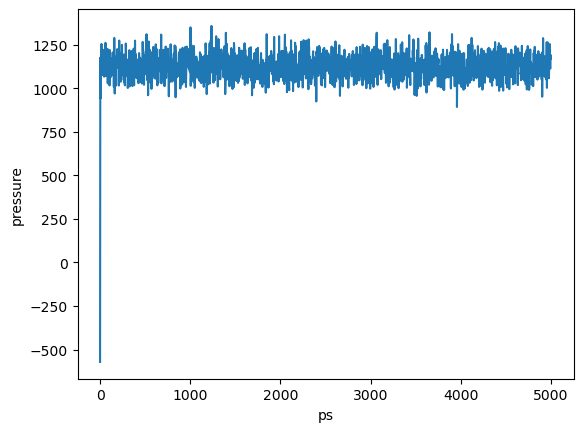

In [23]:
pressure = np.genfromtxt([i for i in open('1/Ar_1_result_to_check.xvg').read().splitlines()
                           if not i.startswith(('#','@'))])
plt.plot(*pressure.T)
plt.xlabel('ps')
plt.ylabel('pressure')
plt.show()

После 50 пикосекунд система приходит в равновесие, поэтому для усреднения буду брать значения давления после этого промежутка времени.

In [3]:
skip = 50

Запросил значения давления из .edr файлов для каждого моделирования, из вывода в консоль получил средние значения давлений и их сохраним в файл average_pressures.txt

In [ ]:
p_list = []
V_list = []
for i in range(1, 12):
    cmd = f'echo -e "10\\n0" | gmx energy -f {i}/Ar_{i}.edr -s {i}/Ar_{i}.tpr -o {i}/Ar_{i}_result.xvg -b 50 -nmol 1000'
    result = subprocess.run(
        cmd,
        shell=True,
        capture_output=True,
        text=True,
        check=False
    )
    output = result.stdout + result.stderr
    match = re.search(r'Pressure\s+(-?\d+\.?\d*)', output)
    if match:
        p_list.append(float(match.group(1)))
    else: print("Not found!")

    with open(f"{i}/Ar_{i}.gro") as gro:
        lines = gro.readlines()
    last_line = lines[-1].strip()
    length = last_line.split(" ")[0]
    volume = float(length)**3 
    V_list.append(volume)


In [2]:
# если оперативная память очистилась, запустить, чтобы загрузить в память V и p
with open("average_pressures_bar.txt") as file:
    p_list_str = file.read().split(" ")
p_list = [float(p) for p in p_list_str]
V_list = []
for i in range(1, 12):
    with open(f"{i}/Ar_{i}.gro") as gro:
            lines = gro.readlines()
    last_line = lines[-1].strip()
    length = last_line.split(" ")[0]
    volume = float(length)**3 
    V_list.append(volume)


Объем в $нм^3$

In [3]:
V_list

[68.92099999999998,
 119.09548799999999,
 205.79700326399998,
 355.61722164019204,
 614.5065589942519,
 1061.8667094436537,
 1834.9047746412425,
 3170.7180404992364,
 5479.002638725202,
 9467.716559717152,
 16360.214215191234]

Давление в $бар$

In [4]:
p_list

[1130.02,
 291.574,
 148.888,
 87.7686,
 52.5294,
 31.2065,
 18.3416,
 10.7198,
 6.24473,
 3.62344,
 2.10131]

Перевел давление в $Па$, а объем в $м^3$

In [5]:
p_list_Pa = [p*100000 for p in p_list]
V_list_m3 = [V*1e-27 for V in V_list]

Исходя из числа частиц в ячейке посчитал молярный объем

In [8]:
N_a = 6e23
N = 1000
V_list_m3_molar = [V/(N/N_a) for V in V_list_m3]

По уравнению состояния идеального газа, посчитал, какой у него будет объем при каждом давлении, полученном из результатов моделирований.

In [9]:
T = 250
R = 8.31
p_list_ig_Pa = [R*T/V for V in V_list_m3_molar]

На одном графике изобразил изотермы (T=250 К) для исследуемого газа (Ar) и для идеального газа.

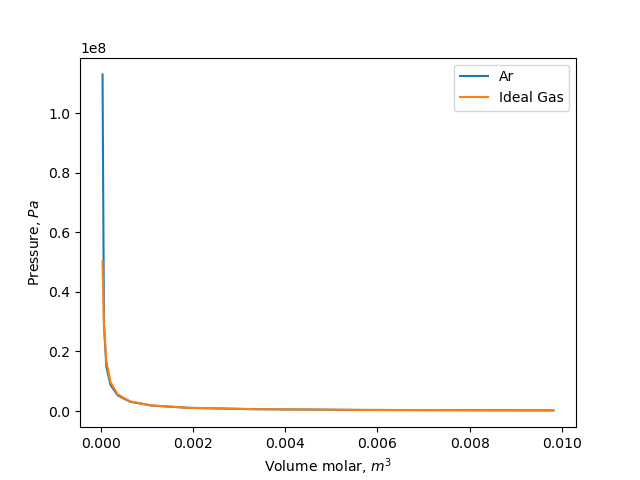

In [11]:
plt.close()
plt.plot(V_list_m3_molar, p_list_Pa, label="Ar")
plt.plot(V_list_m3_molar, p_list_ig_Pa, label="Ideal Gas")
plt.ylabel("Pressure, $Pa$")
plt.xlabel("Volume molar, $m^3$")
plt.legend()
plt.show()

Изотермы совпадают, поэтому поведение аргона можно описать уравнением идеального газа

# Расчет вириальных коэффициентов

Разложение фактора сжимаемости по степеням обратного молярного объема:
$$
Z = \frac{pV_m}{RT} = 1+\frac{B}{V_m} + \frac{C}{V_m^2} + ...
$$
$$
(Z-1)V_m = B + \frac{C}{V_m}
$$
Если построить зависимость $y = (Z-1)V_m$ от $x = \frac{1}{V_m}$, то должна получиться прямая, при этом отрезок, отсекаемый на оси y, будет соответствовать вириальному $B$, а тангенс угла наклона - коэффициенту $C$

Посчитал фактор сжимаемости для каждого давления

In [13]:
z_list = []
for i in list(range(len(V_list_m3_molar))):
    V_m = V_list_m3_molar[i]
    p = p_list_Pa[i]
    z = p*V_m/(R*T)
    z_list.append(z)

In [16]:
z_list

[2.2493027702527066,
 1.0028923557577472,
 0.8849300858330811,
 0.9014303445270574,
 0.932264572997333,
 0.9570294142455851,
 0.9719881419367458,
 0.9816451480301435,
 0.9881557299097886,
 0.9907784228488525,
 0.9928630103255881]

Построил зависимость фактора сжимаемости от давления

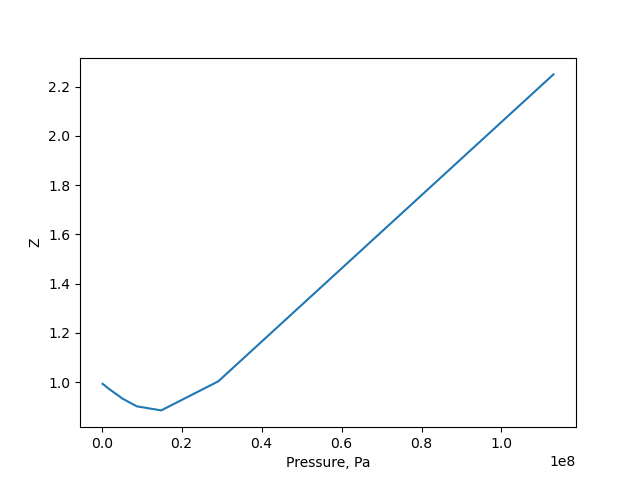

In [14]:
plt.close()
plt.plot(p_list_Pa, z_list)
plt.xlabel("Pressure, Pa")
plt.ylabel("Z")
plt.show()

Построил зависимость $(Z-1)V_m$ от $\frac{1}{V_m}$, чтобы найти вириальные коэффициенты

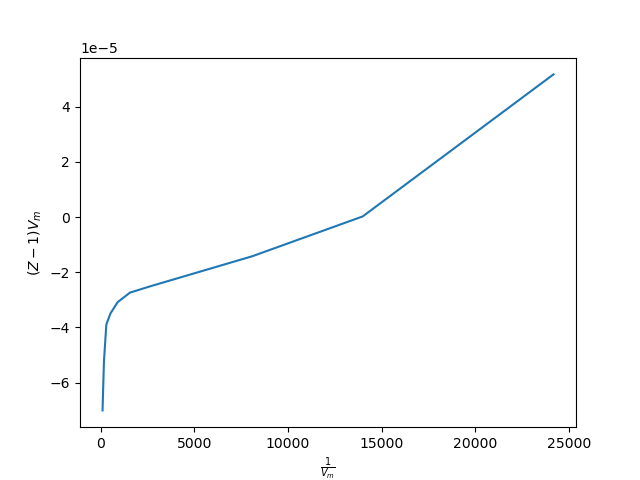

In [18]:
x_list = []
y_list = []
for i in list(range(len(V_list_m3_molar))):
    V_m = V_list_m3_molar[i]
    z = z_list[i]
    x_list.append(1/V_m)
    y = (z-1)*V_m
    y_list.append(y)

plt.close()
plt.plot(x_list, y_list)
plt.xlabel(r"$\frac{1}{V_m}$")
plt.ylabel(r"$(Z-1)V_m$")
plt.show()

Зависимость не линейная, не понятно, как определить вириальные коэффициенты